In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display


In [2]:
region = 'EAS'

## Import China Coal Data

In [3]:
df = pd.read_excel('January 2021 Global Coal Plant Tracker.xlsx', sheet_name = 'Units')

In [4]:
df.columns

Index(['Tracker ID', 'TrackerLOC', 'ParentID', 'Wiki page', 'Country',
       'Subnational unit (province, state)', 'Unit', 'Plant', 'Chinese Name',
       'Other names', 'Sponsor', 'Parent', 'Capacity (MW)', 'Status', 'Year',
       'RETIRED', 'Planned Retire', 'Combustion technology', 'Coal type',
       'Coal source', 'Location', 'Local area (taluk, county)',
       'Major area (prefecture, district)', 'Region', 'Latitude', 'Longitude',
       'Accuracy', 'Permits', 'Captive', 'Captive industry use',
       'Captive residential use', 'Heat rate', 'Emission factor',
       'Annual CO2 (million tonnes / annum)', 'Lifetime CO2', 'Plant age'],
      dtype='object')

In [5]:
## https://pubs.acs.org/doi/abs/10.1021/es3003684 Table S1 
EF = np.exp(-3.64) #g/kg BC/coal

## https://www.nap.edu/read/9736/chapter/8 
HHF = 22.51 #GJ/t

#conversion factors
GJ_to_MwH = .28

Mw_to_MwH = 24 #daily

ton_to_kg = 0.001 #metric tons

In [6]:
mw_to_BC = Mw_to_MwH/GJ_to_MwH/HHF*ton_to_kg*EF #g/day

In [7]:
df_coal_indo = df.loc[(df['Country'] == 'Indonesia')]

In [8]:
df_coal_indo['Status'] = df_coal_indo['Status'].str.lower()

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [9]:
df_coal_indo.loc[:,'BC_daily'] = df_coal_indo.loc[:,'Capacity (MW)']*mw_to_BC

In [10]:
np.unique(df_coal_indo['Status'].values)

array(['announced', 'cancelled', 'construction', 'mothballed',
       'operating', 'permitted', 'pre-permit', 'shelved'], dtype=object)

## Import 2x to test

In [11]:
ds_emis2x = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_2x/2x_{region}_BC/OutputDir/HEMCO_diagnostics.20160*', combine = 'by_coords')

In [12]:
ds_conc2x = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_2x/2x_{region}_BC/OutputDir/GEOSChem.AerosolMass.20160*.nc4', combine = 'by_coords')

## Import data

In [13]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/{region}/OutputDir/GEOSChem.AerosolMass.20160*', combine = 'by_coords')

In [14]:
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/GEOSChem.AerosolMass.20160*', combine = 'by_coords')

In [15]:
ds_conc = xr.concat([ds_delta, ds_base, ds_conc2x], pd.Index(['delta','base', '2x'], name = 'run'))

In [16]:
ds_emisdelta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/{region}/OutputDir/HEMCO_diagnostics.20160*.nc', combine = 'by_coords')

In [17]:
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/HEMCO_diagnostics.20160*', combine = 'by_coords')

In [18]:
ds_emis = xr.concat([ds_emisdelta, ds_emisbase, ds_emis2x], pd.Index(['delta','base', '2x'], name = 'run'))

## Add height to data

In [19]:
height = pd.read_excel('gc_altitude.xlsx')

In [20]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [21]:
ds_emis = xr.merge([ds_emis, height_ds], join = 'inner')
ds_conc = xr.merge([ds_conc, height_ds], join = 'inner')

In [22]:
ds_base = xr.merge([ds_base, height_ds], join = 'inner')
ds_conc2x = xr.merge([ds_conc2x, height_ds], join = 'inner')

In [23]:
sec_day = 86400

In [24]:
utils.combine_BC(ds_emis)

## Import our Emissions Forcing

In [50]:
df = pd.read_excel('January 2021 Global Coal Plant Tracker.xlsx', sheet_name = 'Units') #GEM Data

In [51]:
## https://pubs.acs.org/doi/abs/10.1021/es3003684 Table S1 
EF = np.exp(-3.64) #g/kg BC/coal

## https://www.nap.edu/read/9736/chapter/8 
HHF = 22.51 #GJ/t

#conversion factors
GJ_to_MwH = .28

Mw_to_MwH = 24 #daily

ton_to_kg = 0.001 #metric tons

In [25]:
mw_to_BC = Mw_to_MwH/GJ_to_MwH/HHF*ton_to_kg*EF #g/day

### Focus on one region

In [26]:
df_coal_indo = df.loc[(df['Country'] == 'Indonesia')]

In [27]:
df_coal_indo['Status'] = df_coal_indo['Status'].str.lower()

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [47]:
df_coal_indo.loc[:,'BC_daily'] = df_coal_indo.loc[:,'Capacity (MW)']*mw_to_BC

In [48]:
np.unique(df_coal_indo['Status'].values)

array(['announced', 'cancelled', 'construction', 'mothballed',
       'operating', 'permitted', 'pre-permit', 'shelved'], dtype=object)

### Regrid Data

In [49]:
df_coal_indo = df_coal_indo.groupby(['Latitude','Longitude','Status']).agg({'ParentID':'first','Plant':'first', 'Country':'first',
       'Subnational unit (province, state)':'first', 'Plant':'first',
       'Sponsor':'first', 'Parent':'first', 'Capacity (MW)':'sum',  'Year':'first',
       'RETIRED':'first', 'Planned Retire':'first', 'Combustion technology':'first', 'Coal type':'first',
       'Coal source':'first', 'Location':'first', 'Local area (taluk, county)':'first',
       'Major area (prefecture, district)':'first', 'Region':'first',
       'Accuracy':'first', 'Permits':'first', 'Captive':'first', 'Captive industry use':'first',
       'Captive residential use':'first', 'Heat rate':'mean', 'Emission factor':'mean',
       'Annual CO2 (million tonnes / annum)':'sum', 'Lifetime CO2':'sum', 'Plant age':'mean', 'BC_daily':'mean'})

In [50]:
#check to make sure there are no duplicated ones
df_coal_indo[df_coal_indo.index.duplicated(keep = False)] 

,,,ParentID,Plant,Country,"Subnational unit (province, state)",Sponsor,Parent,Capacity (MW),Year,RETIRED,Planned Retire,...,Permits,Captive,Captive industry use,Captive residential use,Heat rate,Emission factor,Annual CO2 (million tonnes / annum),Lifetime CO2,Plant age,BC_daily
Latitude,Longitude,Status,,,,,,,,,,,,,,,,,,,,,


In [51]:
ds_indo = xr.Dataset.from_dataframe(df_coal_indo)

ds_indo['Latitude'] = ds_indo['Latitude'].astype('float64')

In [52]:
ds_indo = ds_indo.rename({'Latitude':'latitude','Longitude':'longitude'})

In [53]:
ds_indo['BC_op'] = ds_indo.sel(Status = 'operating')['BC_daily']
ds_indo['BC_perm'] = ds_indo.sel(Status = 'permitted')['BC_daily']
ds_indo['BC_const'] = ds_indo.sel(Status = 'construction')['BC_daily']

In [54]:
ds_indo = ds_indo.fillna(0)

In [55]:
regridder = xe.Regridder(ds_indo, ds_base, 'nearest_d2s') #check this usage
regridder

xESMF Regridder 
Regridding algorithm:       nearest_d2s 
Weight filename:            nearest_d2s_165x166_46x72.nc 
Reuse pre-computed weights? False 
Input grid shape:           (165, 166) 
Output grid shape:          (46, 72) 
Periodic in longitude?      False

In [57]:
years = 9
time = pd.date_range(Conc_out['time'].max().values + pd.Timedelta(days=1) , periods = 365*9)

In [58]:
regrid_out = xr.Dataset(
    data_vars = dict(f = (["lat","lon","time","emis_profile"], 
                          np.zeros([ len(ds_base.lat),len(ds_base.lon),len(time),len(['BC_op','BC_perm','BC_const'])]))),
    coords = dict(
        lat = ds_base.lat,
        lon = ds_base.lon,
        time = time,
        emis_profile = ['BC_op','BC_perm','BC_const']

    )

)

In [59]:
for p in ['BC_op','BC_perm','BC_const']:
    for t in regrid_out['time']:
        regrid_out['f'].loc[dict(emis_profile = p, time = t)] = regridder(ds_indo[p])

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [61]:
regrid_out['AREA'] = ds_emis['AREA'].isel(time = 0)
regrid_out['dz'] = ds_emis['dz']

In [64]:
f = xr.Dataset(
    data_vars = dict(f = (["emis_profile","time"], np.zeros([ len(['BC_op','BC_perm','BC_const']),len(time)]))),
    coords = dict(
        emis_profile = ['BC_op','BC_perm','BC_const'],
        time = time
    )

)

In [70]:
#lev mean of G 
for p in ['BC_op','BC_perm','BC_const']:
    f['f'].loc[dict(emis_profile = p)] = (utils.global_w_mean(regrid_out.loc[dict(emis_profile = p)], 'f')).sel(run = 'base')


## Test our old method against the new

In [60]:
for ds in [ds_emisdelta, ds_emisbase, ds_emis2x]:
    utils.combine_BC(ds)
    
ds_emisbase = xr.merge([ds_emisbase, height_ds], join = 'inner')
ds_emisdelta = xr.merge([ds_emisdelta, height_ds], join = 'inner')
ds_base = xr.merge([ds_base, height_ds], join = 'inner')
ds_delta = xr.merge([ds_delta, height_ds], join = 'inner')
ds_conc2x = xr.merge([ds_conc2x, height_ds], join = 'inner')
ds_emis2x = xr.merge([ds_emis2x, height_ds], join = 'inner')

In [61]:
def calc_δc_δt(ds_delta, ds_base, conc_species):
    ds_delta['conc_dif'] = (utils.global_w_mean(ds_delta, conc_species)- 
                            utils.global_w_mean(ds_base, conc_species))
    δc_δt = ds_delta['conc_dif'].diff('time')
    return(δc_δt)


In [63]:
f = (utils.global_w_mean(ds_emis2x, 'EmisBC_Total') - utils.global_w_mean(ds_emisbase, 'EmisBC_Total'))
f= f.assign_coords(time = np.arange(0,len(f['time']))) 
G = calc_δc_δt(ds_delta, ds_base, 'AerMassBC')
G = G.assign_coords(time = np.arange(0,len(G['time'])))
f0 = (utils.global_w_mean(ds_emisdelta, 'EmisBC_Total') - 
      utils.global_w_mean(ds_emisbase, 'EmisBC_Total')).isel(time = 0)


In [65]:
Ndt = 15
dt = 1 #days
t_range = np.arange(0., dt*Ndt, dt)
Δt = 1


In [66]:
C_df = pd.DataFrame(columns = np.arange(0, len(t_range)), index = t_range)


In [67]:
for i, tp in enumerate(t_range):
    for t in t_range:
        i = int(i)
        C_df[i].loc[t] = utils.G_f_kernel(G, f, t, tp,Δt, dt, f0, ds_output = False)
        

## Define our Conc Difference and Initial Forcing

Conc_out = utils.calc_δc_δt(ds_conc, 'AerMassBC')

f0 = (utils.global_w_mean(ds_emis.sel(run = 'delta'), 'EmisBC_Total') - 
      utils.global_w_mean(ds_emis.sel(run = 'base'), 'EmisBC_Total')).isel(time = 0)


In [25]:
## global mean G

In [55]:
f = (utils.global_w_mean(ds_emis.sel(run = '2x').fillna(0), 'EmisBC_Total') - utils.global_w_mean(ds_emis.sel(run = 'base').fillna(0), 'EmisBC_Total'))
f= f.assign_coords(time = np.arange(0,len(f['time']))) #inputting a x2 until we get our doubled emissions as daily data
G = utils.calc_δc_δt_mean(ds_conc.fillna(0), 'AerMassBC')
G = G.assign_coords(time = np.arange(.5,len(G['time'])+.5))

f0 = (utils.global_w_mean(ds_emis.sel(run = 'delta').fillna(0), 'EmisBC_Total') - 
      utils.global_w_mean(ds_emis.sel(run = 'base').fillna(0), 'EmisBC_Total')).isel(time = 0)


In [56]:
G = G.rename({'time':'tp'})

## Vectorize and Ufunc the Runs to get G

In [58]:
G2, f2 = xr.broadcast(G/f0.values,f)

In [60]:
G2 = G2.chunk({"tp":-1, "time":1})

In [64]:
def my_shift(arr, num, fill_value=0):
    num = int(num)
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    else:
        result[:] = arr
    return result


In [65]:
shifted_G = xr.apply_ufunc(
    my_shift,
    G2.values,
    G2.tp,
    input_core_dims = [["time"], []],
    output_core_dims = [["time"]],
    dask="parallelized",
    vectorize=True,
    kwargs={"fill_value":0.}
    )

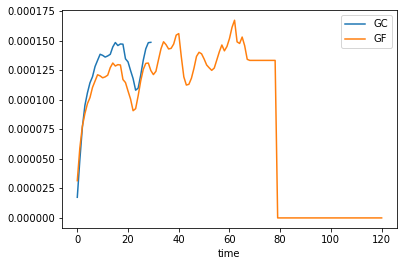

In [71]:
(utils.global_w_mean(ds_conc.sel(run = '2x'), 'AerMassBC') - 
utils.global_w_mean(ds_conc.sel(run = 'base').isel(time = slice(0,30)), 'AerMassBC')).assign_coords(time = np.arange(0,30)).plot(label = 'GC')
((shifted_G*f2).sum(dim = 'tp')).plot(label = 'GF')
#plt.plot(C_df.sum(axis = 1), label = 'GF old');
plt.legend()

In [62]:
for idx,t in enumerate(np.arange(0,20)):
    G2.loc[dict(time = t)] = G2.loc[dict(time = t)].shift(s = idx, fill_value = 0)

In [63]:
out = (G2*f2).sel(time = slice(0,20))

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/array/core.py:4346: PerformanceWarning: Increasing number of chunks by factor of 78
  result = blockwise(


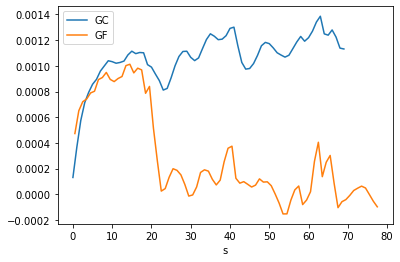

In [65]:

out.sel(time = slice(0,20)).sum(dim = 'time').plot(label = 'GF')
plt.legend()

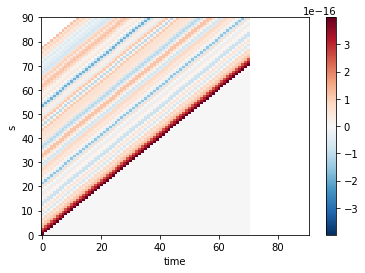

In [201]:
(G2.chunk(5)*f2.chunk(5)).plot()

In [178]:
n = 1
np.append(np.zeros(n),G2.isel(s = slice(n,-1)))

array([0.00000000e+00, 6.58739635e-06, 8.17910289e-06, ...,
                  nan,            nan,            nan])

In [197]:
(G2*f2)

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/array/core.py:4346: PerformanceWarning: Increasing number of chunks by factor of 90
  result = blockwise(


array([[3.99120875e-16, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [3.21449361e-16, 3.99120875e-16, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [2.50949252e-16, 3.21449361e-16, 3.99120875e-16, ...,
                   nan,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/array/core.py:4346: PerformanceWarning: Increasing number of chunks by factor of 90
  result = blockwise(


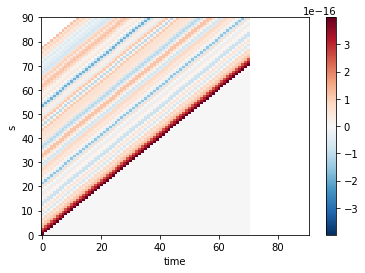

In [198]:
(G2*f2).plot()

In [125]:
# creating a 3X3 Numpy matrix
n_array = np.array([[55, 25, 15],
                    [30, 44, 2],
                    [11, 45, 77]])
  
# Displaying the Matrix
print("Numpy Matrix is:")
print(n_array)
  
# calculating the Trace of a matrix
trace = np.trace(n_array)
  
  
print(trace)

Numpy Matrix is:
[[55 25 15]
 [30 44  2]
 [11 45 77]]
176


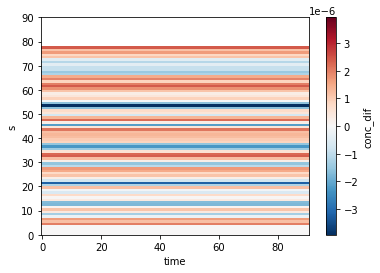

In [124]:
newG.plot()

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/array/core.py:4346: PerformanceWarning: Increasing number of chunks by factor of 90
  result = blockwise(
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/array/core.py:4346: PerformanceWarning: Increasing number of chunks by factor of 90
  result = blockwise(


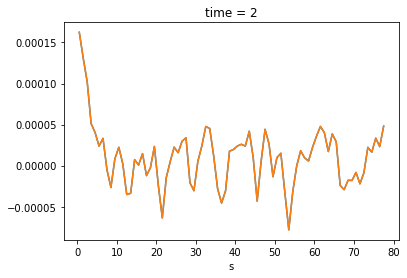

In [106]:
(G2/f0*f2).isel(time = 60).plot()
(G2/f0*f2).isel(time = 2).plot()

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/array/core.py:4346: PerformanceWarning: Increasing number of chunks by factor of 90
  result = blockwise(


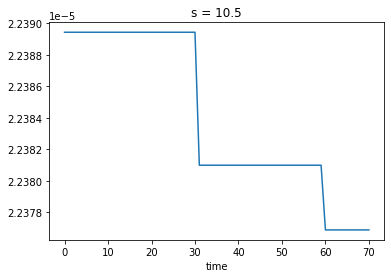

In [101]:
(G2/f0*f2).isel(s = 10).plot()

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/array/core.py:4346: PerformanceWarning: Increasing number of chunks by factor of 90
  result = blockwise(


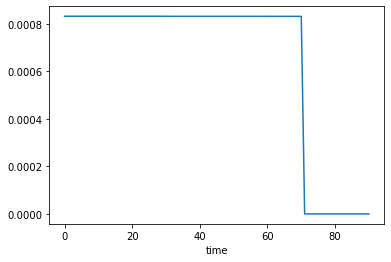

In [98]:
(G2/f0*f2).sum(dim = 's').plot()

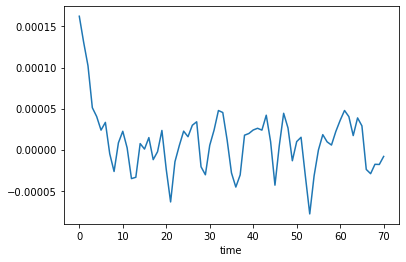

In [82]:
G_f_kernel(G, f, Δt, dt, f0).plot()

In [ ]:
for i, tp in enumerate(t_range):
    for t in t_range:
        i = int(i)
        C_df[i].loc[t] = G_f_kernel(G, f, t, tp,Δt, dt, f0)
        


## Extend Timescale

In [151]:
G_ext = xr.Dataset(
    data_vars = dict(conc_dif = (["time","lev","lat","lon"], 
                          np.zeros([ len(time), 
                                    len(ds_base['lev']),
                                    len(ds_base['lat']),
                                    len(ds_base['lon'])]))),
    coords = dict(
        time = time,
        lev = ("lev", ds_base['lev']),
        lat = ("lat", ds_base['lat']),
        lon = ("lon", ds_base['lon']),
    ))

In [152]:
G_ext = xr.concat([Conc_out,G_ext['conc_dif']], dim = 'time').sortby('time')

In [153]:
G_ext = G_ext.assign_coords(time = np.arange(0.5,len(G_ext['time'])+ 0.5))
f0 = f0.values
f= f.assign_coords(time = np.arange(0,len(f['time'])))

## Greens function convolution

In [163]:
Ndt = 5
dt = 1 #days
tp_range = np.arange(0, dt*Ndt, dt)
t_range = tp_range+0.5
Δt = 1.


In [164]:
C_ds = xr.Dataset(
    data_vars = dict(c = (["emis_profile","tp","lev","lat","lon","time"], 
                          np.zeros([ len(['BC_op','BC_perm','BC_const']), len(tp_range),len(ds_base['lev']),len(ds_base['lat']),len(ds_base['lon']),len(t_range)]))),
    coords = dict(
        emis_profile = ['BC_op','BC_perm','BC_const'],
        tp = tp_range,
        lev = ("lev", ds_base['lev']),
        lat = ("lat", ds_base['lat']),
        lon = ("lon", ds_base['lon']),
        time = t_range
    )

)

In [ ]:
def special_mean(x, drop_min=False):
    s = np.sum(x)
    n = len(x)
    if drop_min:
        s = s - x.min()
    n -= 1
    return s/n

times = pd.date_range('2019-01-01', '2019-01-10', name='time')

data = xr.DataArray(np.random.rand(10, 8, 8), dims=["time", "y", "x"], coords={'time': times})
data = data.chunk({'time':10, 'x':1, 'y':1})

res = xr.apply_ufunc(special_mean, data, input_core_dims=[["time"]], kwargs={'drop_min': True}, dask = 'allowed', vectorize = True)

In [165]:
xr.apply_ufunc(
    utils.G_f_kernel, G_ext, f['f'].sel(emis_profile = p), t, tp,Δt, dt, f0)

ValueError: indexes along dimension 'time' are not equal

In [162]:
%%timeit
for p in ['BC_op','BC_perm','BC_const']:
    for t, tp in itertools.product(t_range,tp_range):
        C_ds['c'].loc[dict(emis_profile = p,tp = tp, time = t)] = utils.G_f_kernel(G_ext, f['f'].sel(emis_profile = p), t, tp,Δt, dt, f0)



KeyboardInterrupt: 

In [158]:
C_df = C_ds.isel(lev = 0, emis_profile = 0).sel(lat = 35, lon = 105, method = 'nearest').drop(['lat','lon','lev']).to_dataframe().unstack()['c']